In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [8]:

try:
    train = pd.read_csv('../data/train_clean.csv')
    test = pd.read_csv('../data/test_clean.csv')
    print("Datasets cargados exitosamente")
except FileNotFoundError:
    print("No se encontraron los archivos")
    exit()

print(f"✓ Dataset de entrenamiento: {train.shape}")
print(f"✓ Dataset de prueba: {test.shape}")

Datasets cargados exitosamente
✓ Dataset de entrenamiento: (7030723, 16)
✓ Dataset de prueba: (7027943, 16)


In [ ]:
# DESCRIPCIÓN GENERAL DEL DATASET

print("\n" + "="*80)
print("1. DESCRIPCIÓN GENERAL DEL DATASET")
print("="*80)

def analizar_dataset(df, nombre):
    print(f"\n DATASET {nombre.upper()}")
    print("-" * 50)
    
    print(f"Dimensiones: {df.shape[0]:,} observaciones x {df.shape[1]} variables")
    
    print(f"\nTipos de datos:")
    tipos = df.dtypes.value_counts()
    for tipo, count in tipos.items():
        print(f" {tipo}: {count} variables")
    
    memoria_mb = df.memory_usage(deep=True).sum() / 1024**2
    print(f"\nMemoria utilizada: {memoria_mb:.2f} MB")

    print(f"\nDetalle de variables:")
    print(f"  Variables categóricas: user_id, merchant_id, age_range, gender, label")
    print(f"  Variables numéricas: activity_len, actions_*, unique_*, day_span, has_1111")
    print(f"  Variables temporales: date_min, date_max")
    
    return df.dtypes

print("\n Información detallada por dataset:")
tipos_train = analizar_dataset(train, "ENTRENAMIENTO")
tipos_test = analizar_dataset(test, "PRUEBA")

print(f"\n Comparación de estructuras:")
columnas_comunes = set(train.columns) & set(test.columns)
columnas_solo_train = set(train.columns) - set(test.columns)
columnas_solo_test = set(test.columns) - set(train.columns)

print(f" Columnas comunes: {len(columnas_comunes)}")
if columnas_solo_train:
    print(f" Solo en train: {list(columnas_solo_train)}")
if columnas_solo_test:
    print(f" Solo en test: {list(columnas_solo_test)}")


1. DESCRIPCIÓN GENERAL DEL DATASET

 Información detallada por dataset:

 DATASET ENTRENAMIENTO
--------------------------------------------------
Dimensiones: 7,030,723 observaciones x 16 variables

Tipos de datos:
 int64: 14 variables
 object: 2 variables

Memoria utilizada: 1649.24 MB

Detalle de variables:
  Variables categóricas: user_id, merchant_id, age_range, gender, label
  Variables numéricas: activity_len, actions_*, unique_*, day_span, has_1111
  Variables temporales: date_min, date_max

 DATASET PRUEBA
--------------------------------------------------
Dimensiones: 7,027,943 observaciones x 16 variables

Tipos de datos:
 int64: 13 variables
 object: 2 variables
 float64: 1 variables

Memoria utilizada: 1648.58 MB

Detalle de variables:
  Variables categóricas: user_id, merchant_id, age_range, gender, label
  Variables numéricas: activity_len, actions_*, unique_*, day_span, has_1111
  Variables temporales: date_min, date_max

 Comparación de estructuras:
 Columnas comunes:

In [ ]:

# ANÁLISIS DE VARIABLES NUMÉRICAS

variables_numericas = [
    'activity_len', 'actions_0', 'actions_2', 'actions_3',
    'unique_items', 'unique_categories', 'unique_brands', 
    'day_span', 'has_1111'
]

variables_ordinales = ['age_range', 'gender']

def estadisticas_descriptivas(df, variables, nombre_dataset):
    print(f"\n ESTADÍSTICAS DESCRIPTIVAS - {nombre_dataset.upper()}")
    print("-" * 60)
    
    # Seleccionar solo variables que existen en el dataset
    vars_disponibles = [var for var in variables if var in df.columns]
    
    if not vars_disponibles:
        print("No se encontraron variables numéricas")
        return

    stats = df[vars_disponibles].describe()
    
    stats_extra = pd.DataFrame({
        'missing': df[vars_disponibles].isnull().sum(),
        'missing_pct': (df[vars_disponibles].isnull().sum() / len(df) * 100),
        'zeros': (df[vars_disponibles] == 0).sum(),
        'zeros_pct': ((df[vars_disponibles] == 0).sum() / len(df) * 100)
    })

    print("\n Medidas de tendencia central y dispersion:")
    print(stats.round(3))
    
    print(f"\n Valores faltantes y ceros:")
    print(stats_extra.round(2))
    
    print(f"\n Análisis detallado por variable:")
    for var in vars_disponibles:
        serie = df[var].dropna()
        if len(serie) == 0:
            continue
            
        print(f"\n {var.upper()}:")
        print(f"    - Rango: [{serie.min():.1f}, {serie.max():.1f}]")
        print(f"    - Media: {serie.mean():.3f} ± {serie.std():.3f}")
        print(f"    - Mediana: {serie.median():.1f}")
        print(f"    - Valores únicos: {serie.nunique():,}")
        
        # Percentiles
        p25, p75 = serie.quantile([0.25, 0.75])
        iqr = p75 - p25
        print(f"    - IQR: {iqr:.3f} (Q1={p25:.1f}, Q3={p75:.1f})")
        
        # Detección de outliers usando IQR
        limite_inf = p25 - 1.5 * iqr
        limite_sup = p75 + 1.5 * iqr
        outliers = ((serie < limite_inf) | (serie > limite_sup)).sum()
        outliers_pct = outliers / len(serie) * 100
        print(f"    - Outliers potenciales: {outliers:,} ({outliers_pct:.2f}%)")

# Análizar train
estadisticas_descriptivas(train, variables_numericas, "ENTRENAMIENTO")

# Analizar test (solo si tiene las mismas variables)
estadisticas_descriptivas(test, variables_numericas, "PRUEBA")


 ESTADÍSTICAS DESCRIPTIVAS - ENTRENAMIENTO
------------------------------------------------------------

 Medidas de tendencia central y dispersion:
       activity_len    actions_0    actions_2    actions_3  unique_items  unique_categories  unique_brands     day_span     has_1111
count   7030723.000  7030723.000  7030723.000  7030723.000   7030723.000        7030723.000    7030723.000  7030723.000  7030723.000
mean          3.499        3.447        0.233        0.215         2.267              1.347          1.046        7.373        0.198
std           5.550       11.546        0.727        0.932         4.900              1.103          0.312       25.831        0.399
min           0.000        0.000        0.000        0.000         0.000              0.000          0.000        0.000        0.000
25%           1.000        1.000        0.000        0.000         1.000              1.000          1.000        0.000        0.000
50%           1.000        1.000        0.000       

In [ ]:

# ANÁLISIS DE VARIABLES CATEGÓRICAS

def analizar_categoricas(df, nombre_dataset):
    print(f"\n  VARIABLES CATEGÓRICAS - {nombre_dataset.upper()}")
    print("-" * 50)
    
    variables_cat = ['age_range', 'gender', 'label']
    
    for var in variables_cat:
        if var not in df.columns:
            continue
            
        print(f"\n  {var.upper()}:")
        
        conteos = df[var].value_counts(dropna=False)
        porcentajes = df[var].value_counts(normalize=True, dropna=False) * 100
        
        tabla = pd.DataFrame({
            'Conteo': conteos,
            'Porcentaje': porcentajes
        }).round(2)
        
        print(tabla)

        print(f"    - Valores únicos: {df[var].nunique()}")
        print(f"    - Valores nulos: {df[var].isnull().sum():,} ({df[var].isnull().sum()/len(df)*100:.2f}%)")

analizar_categoricas(train, "ENTRENAMIENTO")
analizar_categoricas(test, "PRUEBA")



  VARIABLES CATEGÓRICAS - ENTRENAMIENTO
--------------------------------------------------

  AGE_RANGE:
    Conteo  Porcentaje
3  1913722       27.22
4  1459923       20.76
0  1371222       19.50
5   752927       10.71
2   731938       10.41
6   655922        9.33
7   124493        1.77
8    20290        0.29
1      286        0.00
    - Valores únicos: 9
    - Valores nulos: 0 (0.00%)

  GENDER:
    Conteo  Porcentaje
0  5101730       72.56
1  1618110       23.01
2   310883        4.42
    - Valores únicos: 3
    - Valores nulos: 0 (0.00%)

  LABEL:
     Conteo  Porcentaje
-1  6769859       96.29
 0   244912        3.48
 1    15952        0.23
    - Valores únicos: 3
    - Valores nulos: 0 (0.00%)

  VARIABLES CATEGÓRICAS - PRUEBA
--------------------------------------------------

  AGE_RANGE:
    Conteo  Porcentaje
3  1916611       27.27
4  1460542       20.78
0  1364985       19.42
5   752608       10.71
2   733323       10.43
6   650358        9.25
7   128644        1.83
8    20

In [ ]:
# ANÁLISIS DE VARIABLES TEMPORALES

def analizar_temporales(df, nombre_dataset):
    print(f"\n VARIABLES TEMPORALES - {nombre_dataset.upper()}")
    print("-" * 50)

    for col in ['date_min', 'date_max']:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    if 'date_min' in df.columns:
        fecha_min = df['date_min'].dropna()
        print(f"\n  • DATE_MIN:")
        if len(fecha_min) > 0:
            print(f"    - Rango: {fecha_min.min()} a {fecha_min.max()}")
            print(f"    - Valores no nulos: {len(fecha_min):,} ({len(fecha_min)/len(df)*100:.2f}%)")
            
            meses = fecha_min.dt.month.value_counts().sort_index()
            print(f"    - Distribución por mes: {dict(meses)}")
        else:
            print("    - No hay fechas válidas")
    
    if 'date_max' in df.columns:
        fecha_max = df['date_max'].dropna()
        print(f"\n  • DATE_MAX:")
        if len(fecha_max) > 0:
            print(f"    - Rango: {fecha_max.min()} a {fecha_max.max()}")
            print(f"    - Valores no nulos: {len(fecha_max):,} ({len(fecha_max)/len(df)*100:.2f}%)")
        else:
            print("    - No hay fechas válidas")
    
    if 'day_span' in df.columns:
        span = df['day_span'].dropna()
        print(f"\n  • DAY_SPAN (días entre primera y última interacción):")
        if len(span) > 0:
            print(f"    - Media: {span.mean():.2f} días")
            print(f"    - Mediana: {span.median():.0f} días")
            print(f"    - Máximo: {span.max():.0f} días")
            print(f"    - Usuarios con span = 0: {(span == 0).sum():,} ({(span == 0).sum()/len(span)*100:.2f}%)")
        else:
            print("    - No hay datos de span disponibles")

analizar_temporales(train, "ENTRENAMIENTO")
analizar_temporales(test, "PRUEBA")



 VARIABLES TEMPORALES - ENTRENAMIENTO
--------------------------------------------------

  • DATE_MIN:
    - Rango: 2014-05-11 00:00:00 a 2014-11-12 00:00:00
    - Valores no nulos: 7,027,748 (99.96%)
    - Distribución por mes: {5: 473191, 6: 876483, 7: 691220, 8: 704240, 9: 910835, 10: 1245551, 11: 2126228}

  • DATE_MAX:
    - Rango: 2014-05-11 00:00:00 a 2014-11-12 00:00:00
    - Valores no nulos: 7,027,748 (99.96%)

  • DAY_SPAN (días entre primera y última interacción):
    - Media: 7.37 días
    - Mediana: 0 días
    - Máximo: 184 días
    - Usuarios con span = 0: 5,630,998 (80.09%)

 VARIABLES TEMPORALES - PRUEBA
--------------------------------------------------

  • DATE_MIN:
    - Rango: 2014-05-11 00:00:00 a 2014-11-12 00:00:00
    - Valores no nulos: 7,024,937 (99.96%)
    - Distribución por mes: {5: 475364, 6: 875377, 7: 693543, 8: 701605, 9: 910088, 10: 1244282, 11: 2124678}

  • DATE_MAX:
    - Rango: 2014-05-11 00:00:00 a 2014-11-12 00:00:00
    - Valores no nulos: 7

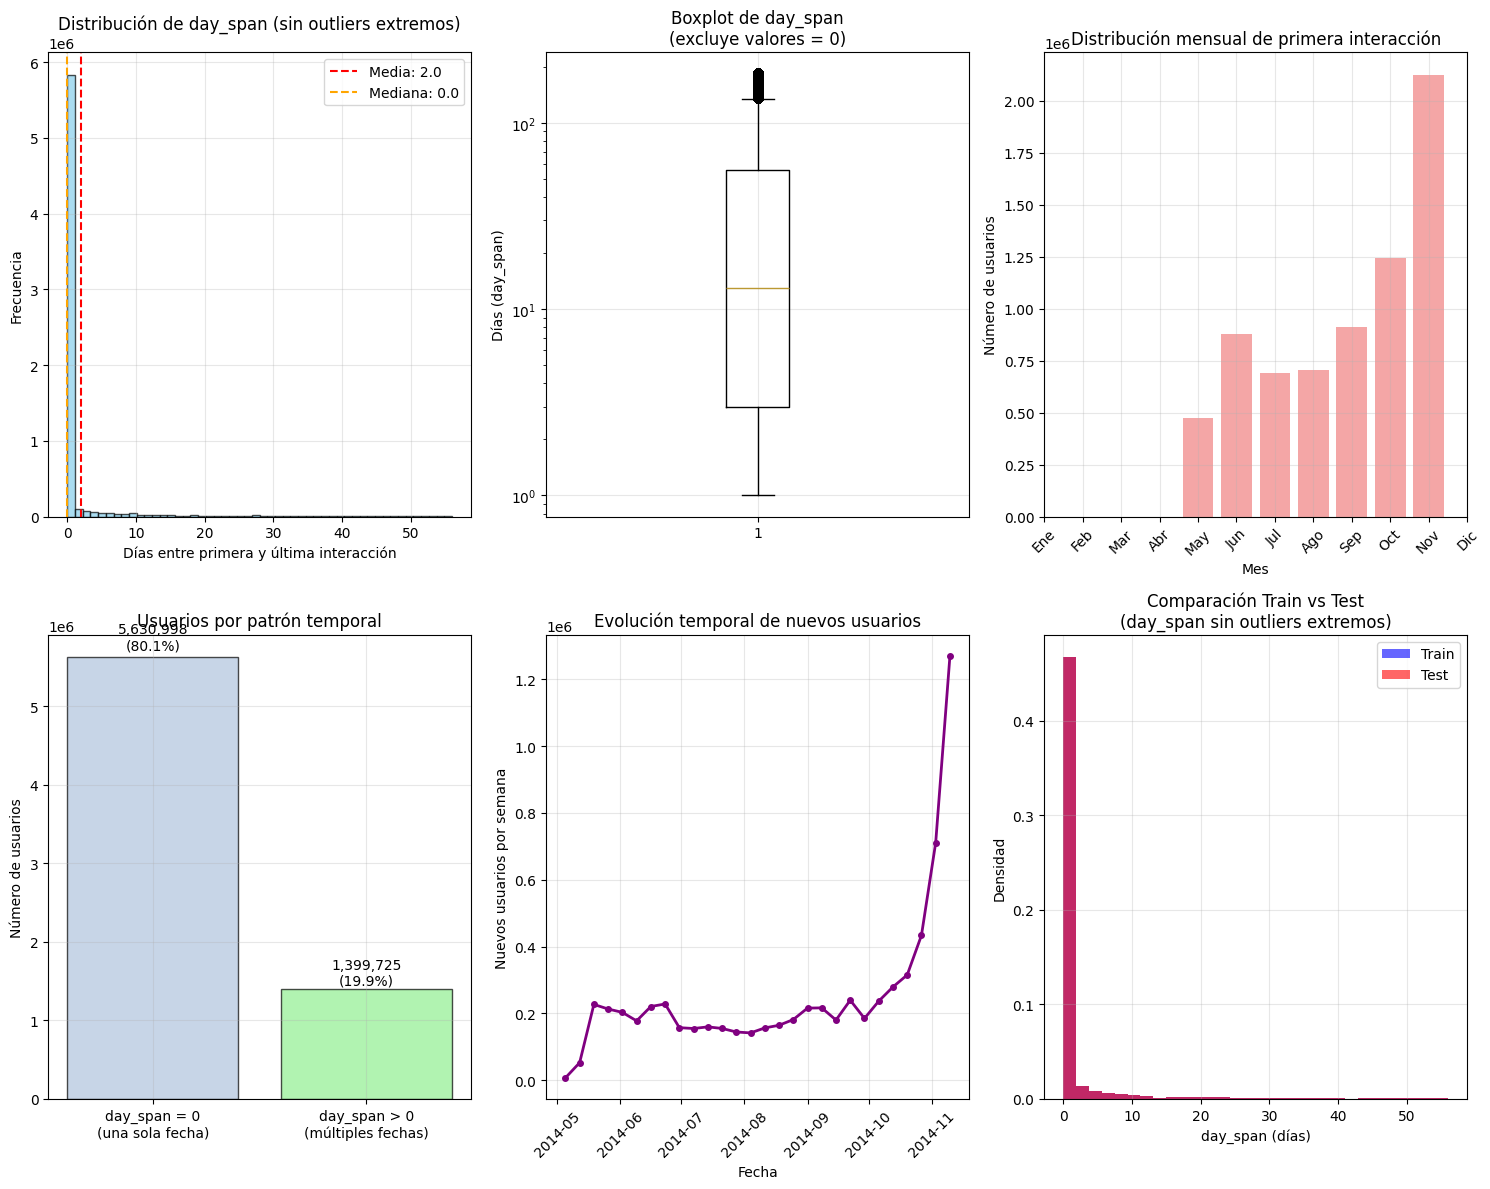


ESTADÍSTICAS ADICIONALES - VARIABLES TEMPORALES

DAY_SPAN - TRAIN:
  • Usuarios con una sola fecha (day_span=0): 5,630,998 (80.1%)
  • Usuarios con múltiples fechas (day_span>0): 1,399,725 (19.9%)
  • Entre usuarios con day_span > 0:
    - Promedio: 37.0 días
    - Mediana: 13.0 días
    - Rango: 1 - 184 días

DAY_SPAN - TEST:
  • Usuarios con una sola fecha (day_span=0): 5,626,484 (80.1%)
  • Usuarios con múltiples fechas (day_span>0): 1,401,459 (19.9%)


In [ ]:
# GRÁFICOS EXPLORATORIOS - VARIABLES TEMPORALES

plt.figure(figsize=(15, 12))

# Convertir fechas si es necesario
for col in ['date_min', 'date_max']:
    if col in train.columns and train[col].dtype == 'object':
        train[col] = pd.to_datetime(train[col], errors='coerce')
    if col in test.columns and test[col].dtype == 'object':
        test[col] = pd.to_datetime(test[col], errors='coerce')

# 1. Histograma de day_span
plt.subplot(2, 3, 1)
if 'day_span' in train.columns:
    # Filtrar outliers extremos para mejor visualización
    day_span_clean = train['day_span'].dropna()
    day_span_clean = day_span_clean[day_span_clean <= day_span_clean.quantile(0.95)]
    
    plt.hist(day_span_clean, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(day_span_clean.mean(), color='red', linestyle='--', label=f'Media: {day_span_clean.mean():.1f}')
    plt.axvline(day_span_clean.median(), color='orange', linestyle='--', label=f'Mediana: {day_span_clean.median():.1f}')
    plt.xlabel('Días entre primera y última interacción')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de day_span (sin outliers extremos)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 2. Boxplot de day_span
plt.subplot(2, 3, 2)
if 'day_span' in train.columns:
    # Usar log scale para mejor visualización debido a outliers
    day_span_nonzero = train['day_span'].dropna()
    day_span_nonzero = day_span_nonzero[day_span_nonzero > 0]
    
    plt.boxplot(day_span_nonzero, vert=True)
    plt.ylabel('Días (day_span)')
    plt.title('Boxplot de day_span\n(excluye valores = 0)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

# 3. Distribución mensual de date_min
plt.subplot(2, 3, 3)
if 'date_min' in train.columns:
    fecha_min_valid = train['date_min'].dropna()
    if len(fecha_min_valid) > 0:
        monthly_counts = fecha_min_valid.dt.month.value_counts().sort_index()
        months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
        
        plt.bar(monthly_counts.index, monthly_counts.values, color='lightcoral', alpha=0.7)
        plt.xlabel('Mes')
        plt.ylabel('Número de usuarios')
        plt.title('Distribución mensual de primera interacción')
        plt.xticks(range(1, 13), [months[i-1] for i in range(1, 13)], rotation=45)
        plt.grid(True, alpha=0.3)

# 4. Usuarios con day_span = 0 vs > 0
plt.subplot(2, 3, 4)
if 'day_span' in train.columns:
    span_data = train['day_span'].dropna()
    span_zero = (span_data == 0).sum()
    span_nonzero = (span_data > 0).sum()
    
    categories = ['day_span = 0\n(una sola fecha)', 'day_span > 0\n(múltiples fechas)']
    counts = [span_zero, span_nonzero]
    colors = ['lightsteelblue', 'lightgreen']
    
    bars = plt.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Número de usuarios')
    plt.title('Usuarios por patrón temporal')
    plt.xticks(rotation=0)
    
    # Agregar etiquetas con porcentajes
    total = span_zero + span_nonzero
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{count:,}\n({count/total*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    plt.grid(True, alpha=0.3)

# 5. Evolución temporal (si hay suficientes datos)
plt.subplot(2, 3, 5)
if 'date_min' in train.columns:
    fecha_min_valid = train['date_min'].dropna()
    if len(fecha_min_valid) > 0:
        # Agrupar por semana para ver tendencias
        weekly_data = fecha_min_valid.dt.to_period('W').value_counts().sort_index()
        
        if len(weekly_data) > 1:
            plt.plot(weekly_data.index.to_timestamp(), weekly_data.values, 
                    marker='o', linewidth=2, markersize=4, color='purple')
            plt.xlabel('Fecha')
            plt.ylabel('Nuevos usuarios por semana')
            plt.title('Evolución temporal de nuevos usuarios')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'Datos insuficientes\npara mostrar evolución', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Evolución temporal')

# 6. Comparación train vs test (day_span)
plt.subplot(2, 3, 6)
if 'day_span' in train.columns and 'day_span' in test.columns:
    train_span = train['day_span'].dropna()
    test_span = test['day_span'].dropna()
    
    # Filtrar outliers para mejor visualización
    train_span_clean = train_span[train_span <= train_span.quantile(0.95)]
    test_span_clean = test_span[test_span <= test_span.quantile(0.95)]
    
    plt.hist(train_span_clean, bins=30, alpha=0.6, label='Train', color='blue', density=True)
    plt.hist(test_span_clean, bins=30, alpha=0.6, label='Test', color='red', density=True)
    plt.xlabel('day_span (días)')
    plt.ylabel('Densidad')
    plt.title('Comparación Train vs Test\n(day_span sin outliers extremos)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print("\n" + "="*60)
print("ESTADÍSTICAS ADICIONALES - VARIABLES TEMPORALES")
print("="*60)

if 'day_span' in train.columns:
    span_train = train['day_span'].dropna()
    print(f"\nDAY_SPAN - TRAIN:")
    print(f"  • Usuarios con una sola fecha (day_span=0): {(span_train == 0).sum():,} ({(span_train == 0).mean()*100:.1f}%)")
    print(f"  • Usuarios con múltiples fechas (day_span>0): {(span_train > 0).sum():,} ({(span_train > 0).mean()*100:.1f}%)")
    
    if (span_train > 0).any():
        span_positivo = span_train[span_train > 0]
        print(f"  • Entre usuarios con day_span > 0:")
        print(f"    - Promedio: {span_positivo.mean():.1f} días")
        print(f"    - Mediana: {span_positivo.median():.1f} días")
        print(f"    - Rango: {span_positivo.min():.0f} - {span_positivo.max():.0f} días")

if 'day_span' in test.columns:
    span_test = test['day_span'].dropna()
    print(f"\nDAY_SPAN - TEST:")
    print(f"  • Usuarios con una sola fecha (day_span=0): {(span_test == 0).sum():,} ({(span_test == 0).mean()*100:.1f}%)")
    print(f"  • Usuarios con múltiples fechas (day_span>0): {(span_test > 0).sum():,} ({(span_test > 0).mean()*100:.1f}%)")

In [ ]:
# ANÁLISIS ESPECÍFICO DEL COMPORTAMIENTO DE USUARIOS

def analizar_comportamiento(df, nombre_dataset):
    print(f"\n COMPORTAMIENTO DE USUARIOS - {nombre_dataset.upper()}")
    print("-" * 50)
    
    if 'activity_len' in df.columns:
        print(f"\n  • NIVEL DE ACTIVIDAD:")
        
        df_temp = df.copy()
        df_temp['actividad_nivel'] = pd.cut(
            df_temp['activity_len'], 
            bins=[0, 1, 3, 10, float('inf')], 
            labels=['Baja (1)', 'Media (2-3)', 'Alta (4-10)', 'Muy Alta (>10)'],
            include_lowest=True
        )
        
        actividad_dist = df_temp['actividad_nivel'].value_counts()
        print(f"    Distribución por nivel:")
        for nivel, count in actividad_dist.items():
            pct = count / len(df_temp) * 100
            print(f"    - {nivel}: {count:,} ({pct:.2f}%)")
    
    acciones_cols = ['actions_0', 'actions_2', 'actions_3']
    acciones_disponibles = [col for col in acciones_cols if col in df.columns]
    
    if acciones_disponibles:
        print(f"\n  • TIPOS DE ACCIONES:")
        acciones_totales = df[acciones_disponibles].sum()
        acciones_pct = acciones_totales / acciones_totales.sum() * 100
        
        nombres_acciones = {
            'actions_0': 'Vistas/Clics',
            'actions_2': 'Carrito',
            'actions_3': 'Compras'
        }
        
        for col in acciones_disponibles:
            nombre = nombres_acciones.get(col, col)
            print(f"    - {nombre}: {acciones_totales[col]:,} ({acciones_pct[col]:.2f}%)")
    
    diversidad_cols = ['unique_items', 'unique_categories', 'unique_brands']
    diversidad_disponibles = [col for col in diversidad_cols if col in df.columns]
    
    if diversidad_disponibles:
        print(f"\n  • DIVERSIDAD DE INTERACCIONES:")
        for col in diversidad_disponibles:
            media = df[col].mean()
            mediana = df[col].median()
            print(f"    - {col.replace('unique_', '').title()}: μ={media:.2f}, mediana={mediana:.0f}")

analizar_comportamiento(train, "ENTRENAMIENTO")
analizar_comportamiento(test, "PRUEBA")


 COMPORTAMIENTO DE USUARIOS - ENTRENAMIENTO
--------------------------------------------------

  • NIVEL DE ACTIVIDAD:
    Distribución por nivel:
    - Baja (1): 3,633,744 (51.68%)
    - Media (2-3): 1,725,981 (24.55%)
    - Alta (4-10): 1,188,907 (16.91%)
    - Muy Alta (>10): 482,091 (6.86%)

  • TIPOS DE ACCIONES:
    - Vistas/Clics: 24,235,247 (88.50%)
    - Carrito: 1,636,724 (5.98%)
    - Compras: 1,512,086 (5.52%)

  • DIVERSIDAD DE INTERACCIONES:
    - Items: μ=2.27, mediana=1
    - Categories: μ=1.35, mediana=1
    - Brands: μ=1.05, mediana=1

 COMPORTAMIENTO DE USUARIOS - PRUEBA
--------------------------------------------------

  • NIVEL DE ACTIVIDAD:
    Distribución por nivel:
    - Baja (1): 3,628,073 (51.62%)
    - Media (2-3): 1,729,124 (24.60%)
    - Alta (4-10): 1,188,581 (16.91%)
    - Muy Alta (>10): 482,165 (6.86%)

  • TIPOS DE ACCIONES:
    - Vistas/Clics: 24,315,466 (88.58%)
    - Carrito: 1,640,984 (5.98%)
    - Compras: 1,493,637 (5.44%)

  • DIVERSIDAD DE

In [ ]:

# ANÁLISIS DE LA VARIABLE OBJETIVO (solo para train)

if 'label' in train.columns:
    print(f"\n VARIABLE OBJETIVO (LABEL) - ENTRENAMIENTO")
    print("-" * 50)
    
    label_counts = train['label'].value_counts(dropna=False)
    label_pcts = train['label'].value_counts(normalize=True, dropna=False) * 100
    
    print(f"\nDistribución completa:")
    for valor, count in label_counts.items():
        pct = label_pcts[valor]
        if valor == -1:
            descripcion = "(no son clientes nuevos - contexto)"
        elif valor == 0:
            descripcion = "(clientes nuevos, no recurrentes)"
        elif valor == 1:
            descripcion = "(clientes nuevos, recurrentes)"
        else:
            descripcion = ""
        
        print(f"  • Label {valor}: {count:,} ({pct:.2f}%) {descripcion}")
    
    clientes_nuevos = train[train['label'].isin([0, 1])]
    
    if len(clientes_nuevos) > 0:
        print(f"\nAnálisis para CLIENTES NUEVOS solamente:")
        print(f"  • Total clientes nuevos: {len(clientes_nuevos):,}")
        
        nuevos_counts = clientes_nuevos['label'].value_counts()
        nuevos_pcts = clientes_nuevos['label'].value_counts(normalize=True) * 100
        
        for valor, count in nuevos_counts.items():
            pct = nuevos_pcts[valor]
            tipo = "No recurrentes" if valor == 0 else "Recurrentes"
            print(f"  • {tipo}: {count:,} ({pct:.2f}%)")
        
        if 1 in nuevos_counts and 0 in nuevos_counts:
            ratio = nuevos_counts[0] / nuevos_counts[1]
            print(f"  • Ratio desbalance (0:1): {ratio:.2f}:1")
else:
    print("No se encontró la variable 'label' en el dataset de entrenamiento")




 VARIABLE OBJETIVO (LABEL) - ENTRENAMIENTO
--------------------------------------------------

Distribución completa:
  • Label -1: 6,769,859 (96.29%) (no son clientes nuevos - contexto)
  • Label 0: 244,912 (3.48%) (clientes nuevos, no recurrentes)
  • Label 1: 15,952 (0.23%) (clientes nuevos, recurrentes)

Análisis para CLIENTES NUEVOS solamente:
  • Total clientes nuevos: 260,864
  • No recurrentes: 244,912 (93.88%)
  • Recurrentes: 15,952 (6.12%)
  • Ratio desbalance (0:1): 15.35:1


In [ ]:
#  TABLAS DE FRECUENCIA PARA VARIABLES CATEGÓRICAS

def crear_tablas_frecuencia(df, nombre_dataset):
    print(f"\n TABLAS DE FRECUENCIA - {nombre_dataset.upper()}")
    print("-" * 60)
    
    variables_categoricas = {
        'age_range': {
            0: 'Desconocido',
            1: '<18 años', 
            2: '18-24 años',
            3: '25-29 años',
            4: '30-34 años', 
            5: '35-39 años',
            6: '40-49 años',
            7: '50+ años',
            8: '50+ años'
        },
        'gender': {
            0: 'Femenino',
            1: 'Masculino', 
            2: 'Desconocido'
        },
        'label': {
            -1: 'No cliente nuevo',
            0: 'No recurrente',
            1: 'Recurrente'
        }
    }
    
    for variable, etiquetas in variables_categoricas.items():
        if variable not in df.columns:
            continue
            
        print(f"\n TABLA DE FRECUENCIA: {variable.upper()}")
        print("-" * 40)
        
        frecuencias = df[variable].value_counts(dropna=False).sort_index()
        porcentajes = df[variable].value_counts(normalize=True, dropna=False).sort_index() * 100
        porcentajes_acum = porcentajes.cumsum()
        
        tabla_freq = pd.DataFrame({
            'Valor': frecuencias.index,
            'Etiqueta': [etiquetas.get(val, f'Valor_{val}') for val in frecuencias.index],
            'Frecuencia': frecuencias.values,
            'Porcentaje': porcentajes.values,
            'Porcentaje_Acum': porcentajes_acum.values
        })
        
        tabla_freq['Etiqueta'] = tabla_freq.apply(
            lambda row: 'Valores Faltantes' if pd.isna(row['Valor']) else row['Etiqueta'], 
            axis=1
        )
        
        print(tabla_freq.round(2).to_string(index=False))
        
        total_validos = df[variable].notna().sum()
        total_faltantes = df[variable].isna().sum()
        print(f"\nResumen estadístico:")
        print(f"  • Total observaciones: {len(df):,}")
        print(f"  • Valores válidos: {total_validos:,} ({total_validos/len(df)*100:.2f}%)")
        print(f"  • Valores faltantes: {total_faltantes:,} ({total_faltantes/len(df)*100:.2f}%)")
        print(f"  • Categorías únicas: {df[variable].nunique()}")
        
        if not frecuencias.empty:
            moda = frecuencias.idxmax()
            moda_etiqueta = etiquetas.get(moda, f'Valor_{moda}')
            moda_freq = frecuencias.max()
            moda_pct = porcentajes.max()
            print(f"  • Categoría modal: {moda_etiqueta} ({moda_freq:,} obs, {moda_pct:.2f}%)")

crear_tablas_frecuencia(train, "ENTRENAMIENTO")
crear_tablas_frecuencia(test, "PRUEBA")



 TABLAS DE FRECUENCIA - ENTRENAMIENTO
------------------------------------------------------------

 TABLA DE FRECUENCIA: AGE_RANGE
----------------------------------------
 Valor    Etiqueta  Frecuencia  Porcentaje  Porcentaje_Acum
     0 Desconocido     1371222       19.50            19.50
     1    <18 años         286        0.00            19.51
     2  18-24 años      731938       10.41            29.92
     3  25-29 años     1913722       27.22            57.14
     4  30-34 años     1459923       20.76            77.90
     5  35-39 años      752927       10.71            88.61
     6  40-49 años      655922        9.33            97.94
     7    50+ años      124493        1.77            99.71
     8    50+ años       20290        0.29           100.00

Resumen estadístico:
  • Total observaciones: 7,030,723
  • Valores válidos: 7,030,723 (100.00%)
  • Valores faltantes: 0 (0.00%)
  • Categorías únicas: 9
  • Categoría modal: 25-29 años (1,913,722 obs, 27.22%)

 TABLA DE FRE

In [ ]:
import pandas as pd
import numpy as np

def analizar_cruces_variables(df, nombre_dataset):
    print(f"\nANALISIS DE CRUCES - {nombre_dataset.upper()}")
    print("-" * 60)
    
    # 1. CRUCE: GÉNERO vs EDAD
    if 'gender' in df.columns and 'age_range' in df.columns:
        print(f"\n1. CRUCE: GÉNERO vs RANGO DE EDAD")
        print("-" * 35)
        
        # Tabla cruzada con valores absolutos
        tabla_genero_edad = pd.crosstab(
            df['gender'], 
            df['age_range'], 
            margins=True, 
            margins_name='TOTAL'
        )
        print("Frecuencias absolutas:")
        print(tabla_genero_edad)
        
        # Tabla cruzada con porcentajes por fila
        tabla_genero_edad_pct = pd.crosstab(
            df['gender'], 
            df['age_range'], 
            normalize='index'
        ) * 100
        print(f"\nPorcentajes por género (filas):")
        print(tabla_genero_edad_pct.round(2))
        
        # Insights
        print(f"\nInsights Género vs Edad:")
        if 0 in df['gender'].values:  # Femenino
            femenino_data = df[df['gender'] == 0]['age_range']
            if not femenino_data.empty:
                edad_fem_modal = femenino_data.mode().iloc[0] if not femenino_data.mode().empty else "N/A"
                print(f"   - Grupo etario más común en mujeres: {edad_fem_modal}")
        
        if 1 in df['gender'].values:  # Masculino  
            masculino_data = df[df['gender'] == 1]['age_range']
            if not masculino_data.empty:
                edad_masc_modal = masculino_data.mode().iloc[0] if not masculino_data.mode().empty else "N/A"
                print(f"   - Grupo etario más común en hombres: {edad_masc_modal}")
    
    # 2. CRUCE: ACTIVIDAD vs GÉNERO (solo si tenemos datos de actividad)
    if 'activity_len' in df.columns and 'gender' in df.columns:
        print(f"\n2. CRUCE: NIVEL DE ACTIVIDAD vs GÉNERO")
        print("-" * 40)
        
        # Crear categorías de actividad
        df_temp = df.copy()
        df_temp['nivel_actividad'] = pd.cut(
            df_temp['activity_len'],
            bins=[0, 1, 3, 10, float('inf')],
            labels=['Baja', 'Media', 'Alta', 'Muy Alta'],
            include_lowest=True
        )
        
        # Tabla cruzada
        tabla_actividad_genero = pd.crosstab(
            df_temp['nivel_actividad'],
            df_temp['gender'],
            margins=True,
            margins_name='TOTAL'
        )
        print("Frecuencias absolutas:")
        print(tabla_actividad_genero)
        
        # Porcentajes por columna (género)
        tabla_actividad_genero_pct = pd.crosstab(
            df_temp['nivel_actividad'],
            df_temp['gender'],
            normalize='columns'
        ) * 100
        print(f"\nPorcentajes por género (columnas):")
        print(tabla_actividad_genero_pct.round(2))
        
        # Estadísticas por género
        print(f"\nEstadísticas de actividad por género:")
        for genero in [0, 1, 2]:
            if genero in df['gender'].values:
                subset = df[df['gender'] == genero]['activity_len']
                if not subset.empty:
                    genero_label = {0: 'Femenino', 1: 'Masculino', 2: 'Desconocido'}[genero]
                    print(f"   - {genero_label}: μ={subset.mean():.2f}, σ={subset.std():.2f}, mediana={subset.median():.1f}")
    
    # 3. CRUCE: TIPOS DE ACCIONES vs GÉNERO
    acciones_cols = ['actions_0', 'actions_2', 'actions_3']
    acciones_disponibles = [col for col in acciones_cols if col in df.columns]
    
    if acciones_disponibles and 'gender' in df.columns:
        print(f"\n3. CRUCE: TIPOS DE ACCIONES vs GÉNERO")
        print("-" * 40)
        
        # Calcular promedios por género
        print("Promedio de acciones por género:")
        acciones_por_genero = df.groupby('gender')[acciones_disponibles].mean()
        
        # Corrección del error 'TypeError'
        acciones_por_genero.index = acciones_por_genero.index.to_series().replace({
            0: 'Femenino', 1: 'Masculino', 2: 'Desconocido'
        })
        
        # Renombrar columnas para mejor interpretación
        nombres_columnas = {
            'actions_0': 'Vistas/Clics',
            'actions_2': 'Carrito', 
            'actions_3': 'Compras'
        }
        acciones_por_genero.columns = [nombres_columnas.get(col, col) for col in acciones_por_genero.columns]
        
        print(acciones_por_genero.round(3))
        
        # Análisis de diferencias entre géneros
        print(f"\nAnálisis comparativo de comportamiento:")
        if len(acciones_por_genero) >= 2:
            fem_row = acciones_por_genero.loc['Femenino'] if 'Femenino' in acciones_por_genero.index else None
            masc_row = acciones_por_genero.loc['Masculino'] if 'Masculino' in acciones_por_genero.index else None
            
            if fem_row is not None and masc_row is not None:
                for col in acciones_por_genero.columns:
                    diff = fem_row[col] - masc_row[col]
                    diff_pct = (diff / masc_row[col] * 100) if masc_row[col] > 0 else 0
                    if abs(diff_pct) > 1:  # Solo mostrar diferencias significativas
                        genero_mayor = "MUJERES" if diff > 0 else "HOMBRES"
                        print(f"   - {col}: {genero_mayor} tienen {abs(diff_pct):.1f}% más actividad")
        
        # Calcular ratios de conversión (si tenemos actions_3 como compras)
        if 'actions_3' in df.columns and 'actions_0' in df.columns:
            print(f"\nRatio de conversión (compras/vistas) por género:")
            conversion_ratio = df.groupby('gender').apply(
                lambda x: (x['actions_3'].sum() / x['actions_0'].sum() * 100) 
                if x['actions_0'].sum() > 0 else 0
            )
            
            # Corrección del error 'TypeError'
            conversion_ratio.index = conversion_ratio.index.to_series().replace({
                0: 'Femenino', 1: 'Masculino', 2: 'Desconocido'
            })
            
            # Mostrar con mejor formato
            max_conversion = conversion_ratio.max()
            for genero, ratio in conversion_ratio.items():
                indicador = " (Mayor tasa de conversión)" if ratio == max_conversion else ""
                print(f"   - {genero}: {ratio:.3f}%{indicador}")
        
        # Análisis de engagement (actividad total)
        if len(acciones_disponibles) > 1:
            print(f"\nÍndice de engagement total por género:")
            df_temp = df.copy()
            df_temp['engagement_total'] = df_temp[acciones_disponibles].sum(axis=1)
            
            engagement_por_genero = df_temp.groupby('gender')['engagement_total'].mean()
            
            # Corrección del error 'TypeError'
            engagement_por_genero.index = engagement_por_genero.index.to_series().replace({
                0: 'Femenino', 1: 'Masculino', 2: 'Desconocido'
            })
            
            max_engagement = engagement_por_genero.max()
            for genero, engagement in engagement_por_genero.items():
                indicador = " (Mayor engagement general)" if engagement == max_engagement else ""
                print(f"   - {genero}: {engagement:.3f} acciones promedio{indicador}")

analizar_cruces_variables(train, "ENTRENAMIENTO")

if len(test) > 0:
    analizar_cruces_variables(test, "PRUEBA")


ANALISIS DE CRUCES - ENTRENAMIENTO
------------------------------------------------------------

1. CRUCE: GÉNERO vs RANGO DE EDAD
-----------------------------------
Frecuencias absolutas:
age_range        0    1       2        3        4       5       6       7      8    TOTAL
gender                                                                                   
0          1055097  215  526308  1378682   982344  542894  510188   92999  13003  5101730
1           251543   71  193374   453147   377560  172610  135351   28535   5919  1618110
2            64582    0   12256    81893   100019   37423   10383    2959   1368   310883
TOTAL      1371222  286  731938  1913722  1459923  752927  655922  124493  20290  7030723

Porcentajes por género (filas):
age_range      0    1      2      3      4      5      6     7     8
gender                                                              
0          20.68  0.0  10.32  27.02  19.26  10.64  10.00  1.82  0.25
1          15.55  0.0  11.95 

In [ ]:

#  CRUCES ESPECÍFICOS CON VARIABLE OBJETIVO (solo TRAIN)

if 'label' in train.columns:
    clientes_nuevos = train[train['label'].isin([0, 1])]
    
    if len(clientes_nuevos) > 0:
        print(f"\n ANÁLISIS DE PATRONES EN CLIENTES NUEVOS")
        print(f"   (Excluye registros con label = -1)")
        print("-" * 50)
        
        # 1. RECURRENCIA vs GÉNERO
        if 'gender' in clientes_nuevos.columns:
            print(f"\n1️ RECURRENCIA vs GÉNERO")
            print("-" * 25)
            
            tabla_label_gender = pd.crosstab(
                clientes_nuevos['label'],
                clientes_nuevos['gender'],
                margins=True,
                margins_name='TOTAL'
            )
            print("Frecuencias absolutas:")
            print(tabla_label_gender)
            
            tasas_recurrencia = pd.crosstab(
            clientes_nuevos['label'],
            clientes_nuevos['gender'],
            normalize='columns'
        ).loc[1] * 100

        print(f"\nTasa de recurrencia por género:")

        # Se usa .to_series().replace() para evitar el TypeError
        tasas_recurrencia.index = tasas_recurrencia.index.to_series().replace({
            0: 'Femenino', 1: 'Masculino', 2: 'Desconocido'
        })

        for genero, tasa in tasas_recurrencia.items():
            print(f"  • {genero}: {tasa:.2f}%")
        
        # 2. RECURRENCIA vs EDAD
        if 'age_range' in clientes_nuevos.columns:
            print(f"\n2️ RECURRENCIA vs RANGO DE EDAD")
            print("-" * 30)

            tasas_edad = pd.crosstab(
                clientes_nuevos['label'],
                clientes_nuevos['age_range'],
                normalize='columns'
            ).loc[1] * 100
            
            print(f"Tasa de recurrencia por grupo etario:")
            etiquetas_edad = {
                0: 'Desconocido', 1: '<18', 2: '18-24', 3: '25-29',
                4: '30-34', 5: '35-39', 6: '40-49', 7: '50+', 8: '50+'
            }
            
            for edad, tasa in tasas_edad.items():
                etiqueta = etiquetas_edad.get(edad, f'Edad_{edad}')
                print(f"  • {etiqueta}: {tasa:.2f}%")
        
        # 3. RECURRENCIA vs NIVEL DE ACTIVIDAD
        if 'activity_len' in clientes_nuevos.columns:
            print(f"\n3️  RECURRENCIA vs NIVEL DE ACTIVIDAD")
            print("-" * 35)
            
            stats_actividad = clientes_nuevos.groupby('label')['activity_len'].agg([
                'count', 'mean', 'std', 'median', 'min', 'max'
            ]).round(3)
            
            stats_actividad.index = stats_actividad.index.map({
                0: 'No Recurrentes', 1: 'Recurrentes'
            })
            
            print("Estadísticas de actividad por tipo de cliente:")
            print(stats_actividad)
            
            no_recurrentes = clientes_nuevos[clientes_nuevos['label'] == 0]['activity_len']
            recurrentes = clientes_nuevos[clientes_nuevos['label'] == 1]['activity_len']
            
            if len(no_recurrentes) > 0 and len(recurrentes) > 0:
                diff_medias = recurrentes.mean() - no_recurrentes.mean()
                print(f"\nDiferencia de medias (Recurrentes - No Recurrentes): {diff_medias:.3f}")
                
                if diff_medias > 0:
                    print("  → Los clientes recurrentes tienden a tener MÁS actividad")
                else:
                    print("  → Los clientes recurrentes tienden a tener MENOS actividad")



 ANÁLISIS DE PATRONES EN CLIENTES NUEVOS
   (Excluye registros con label = -1)
--------------------------------------------------

1️ RECURRENCIA vs GÉNERO
-------------------------
Frecuencias absolutas:
gender       0      1      2   TOTAL
label                               
0       165027  69787  10098  244912
1        11387   3969    596   15952
TOTAL   176414  73756  10694  260864

Tasa de recurrencia por género:
  • Femenino: 6.45%
  • Masculino: 5.38%
  • Desconocido: 5.57%

2️ RECURRENCIA vs RANGO DE EDAD
------------------------------
Tasa de recurrencia por grupo etario:
  • Desconocido: 5.82%
  • <18: 0.00%
  • 18-24: 4.93%
  • 25-29: 5.88%
  • 30-34: 6.72%
  • 35-39: 7.00%
  • 40-49: 6.83%
  • 50+: 6.04%
  • 50+: 6.94%

3️  RECURRENCIA vs NIVEL DE ACTIVIDAD
-----------------------------------
Estadísticas de actividad por tipo de cliente:
                 count    mean     std  median  min  max
label                                                   
No Recurrentes  24491

Basado en el análisis de los clientes, se han identificado varios patrones clave que diferencian a los clientes recurrentes de los que no lo son. En primer lugar, al examinar la relación entre la recurrencia y el género, se observa que la tasa de recurrencia en mujeres es notablemente superior a la de los hombres. Este dato sugiere que la fidelización es más alta entre la clientela femenina.

En cuanto a la edad, la recurrencia no se distribuye de manera uniforme. Los grupos etarios con la mayor tasa de recurrencia son los de 40-49 años y 50+ años. Esto indica que los clientes de mediana edad y mayores son los más propensos a volver, a diferencia de los grupos más jóvenes, que muestran una menor propensión.

Por último, el nivel de actividad en el sitio web o plataforma es un predictor significativo. Los clientes recurrentes tienen una actividad promedio considerablemente mayor que los no recurrentes. Esto se refleja en un mayor número de interacciones, lo que subraya una relación directa entre el engagement del cliente y su lealtad. En resumen, los clientes que regresan tienden a ser mujeres de 40 años o más y muestran una actividad más intensa en la plataforma.